In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as pltclr
import matplotlib.patches as patch
import skimage
from skimage.measure import label, regionprops, regionprops_table
import seaborn as sns

/tmp/ipykernel_2568248/3837874603.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp
from utils.data67_processing import CellDataset, SubsetSampler

from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict
from utils.nb_utils import *


%load_ext autoreload
%autoreload 2
%matplotlib inline
import pprint

In [3]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Plot prediction on train cell

In [4]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input2_0_mean)
    return corr_norm


In [5]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler
np.random.seed(1)
torch.random.manual_seed(1)


image_directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

model_name = 'protein1_datanormed_model_pfak2zyxin_aw_mse_corr_500ep'

modelinfo = torch.load('./tensorboard_logs/'+ model_name +'_0/model.pt',  map_location=torch.device(device))

dataset_kwargs = modelinfo['dataset_kwargs']

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])


prediction_result_folder = './zyxin2pfak_results/'

if not os.path.isdir(prediction_result_folder):          
    os.mkdir(prediction_result_folder)

model_prediction_result_folder = './zyxin2pfak_results/' + model_name + '/'

if not os.path.isdir(model_prediction_result_folder):          
    os.mkdir(model_prediction_result_folder)


plot_result_folder = model_prediction_result_folder +'plot'
tiff_result_folder = model_prediction_result_folder +'tiff'

if not os.path.isdir(plot_result_folder):          
    os.mkdir(plot_result_folder)

if not os.path.isdir(tiff_result_folder):          
    os.mkdir(tiff_result_folder)

crop_size = 1024
eval_dataset_kwargs = modelinfo['dataset_kwargs']
eval_dataset_kwargs['transform_kwargs']['crop_size'] = crop_size
eval_dataset_kwargs['transform_kwargs']['rotate'] = False
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)


pred_corr_df = pd.DataFrame(columns=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])

corr_matrix_zp = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)
corr_matrix_zn = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)
corr_matrix_np = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)        
flag_sc_z = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)        
flag_sc_p = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)    
flag_mask = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)    

z_p_corr= np.full([600,1], np.nan)
z_n_corr= np.full([600,1], np.nan)
p_n_corr= np.full([600,1], np.nan)
z_z_corr= np.full([600,1], np.nan)
p_p_corr= np.full([600,1], np.nan)



cell_index = -1
cell_train_test_flag = np.full([600,1], np.nan)
cell_ctrl_Y27_flag = np.full([600,1], np.nan)

for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(100):  
        cell_index = cell_index + 1

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()
        
        zyxin_seg =  sample['output_seg'].detach().cpu().numpy().squeeze()
        pax_seg =  sample['input_seg'].detach().cpu().numpy().squeeze() 


        label_zyxin_seg = label(zyxin_seg)
        regionprops_zyxin_seg = regionprops(label_zyxin_seg,intensity_image=zyx)
        
        label_pax_seg = label(pax_seg)
        regionprops_pax_seg = regionprops(label_pax_seg,intensity_image=pax)
        
        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[dilate_mask>0]    

        for xi in range(0,round(crop_size/32)):
            for yi in range(0,round(crop_size/32)):
                z_patch = zyx[xi*32:xi*32+32,yi*32:yi*32+32]
                p_patch = pax[xi*32:xi*32+32,yi*32:yi*32+32]
                n_patch = pred[xi*32:xi*32+32,yi*32:yi*32+32]
                z_seg_patch = zyxin_seg[xi*32:xi*32+32,yi*32:yi*32+32]
                p_seg_patch = pax_seg[xi*32:xi*32+32,yi*32:yi*32+32]
                mask_patch = mask[xi*32:xi*32+32,yi*32:yi*32+32]                
                
                corr_matrix_zp[cell_index, xi,yi] = normcorr(z_patch[z_patch>-0.10],p_patch[p_patch>-0.10])
                corr_matrix_zn[cell_index, xi,yi] = normcorr(z_patch[z_patch>-0.10],n_patch[n_patch>-0.10])
                corr_matrix_np[cell_index, xi,yi] = normcorr(n_patch[n_patch>-0.10],p_patch[p_patch>-0.10])
                
                flag_sc_z[cell_index, xi,yi] = z_seg_patch.mean()
                flag_sc_p[cell_index, xi,yi] = p_seg_patch.mean()
                flag_mask[cell_index, xi,yi] = mask_patch.mean()
                    
        z_p_corr[cell_index]  = normcorr(zyxin_values,pfak_values)
        z_n_corr[cell_index]  = normcorr(zyxin_values,nn_values)
        p_n_corr[cell_index]  = normcorr(pfak_values,nn_values)
        z_z_corr[cell_index]  = normcorr(zyxin_values,zyxin_values)
        p_p_corr[cell_index]  = normcorr(pfak_values,pfak_values)
        
        train_test_flag= 'train'
        cell_train_test_flag[cell_index] = 1
            
        if cell == 'cell_3' or cell == 'cell_6' :
            train_test_flag= 'test'
            cell_train_test_flag[cell_index] = 0
            
        if cell == 'cell_1' or cell == 'cell_2'  or cell == 'cell_3':
            cell_ctrl_Y27_flag[cell_index] = 1
        else:
            cell_ctrl_Y27_flag[cell_index] = 0
            
            
        s = pd.Series([cell, frame, train_test_flag,z_p_corr[cell_index] , z_n_corr[cell_index] , p_n_corr[cell_index]  ],
                        index=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])
        pred_corr_df = pred_corr_df._append(s,ignore_index=True)

        pred_corr_df.to_csv(os.path.join(model_prediction_result_folder,model_name+'p2z_prediction_300epochs_corr_gridplot.csv'))

        fig,ax=plt.subplots(2,3,figsize=(8, 5*1), dpi=200)

        ax[0,0].set_title('pFAK', fontsize=8)
        ax[0,0].imshow(pax,  cmap='gray', vmax=1, vmin=0)
        if cell == 'cell_3' or cell == 'cell_6' :
            ax[0,0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0,0].set_xlabel('Training set: ' + cell)
            
        for yline in range(0,1024,32):
            ax[0,0].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[0,0].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[0,0].set_xlim(0,1024) 
        ax[0,0].set_ylim(0,1024) 
        ax[0,0].axis('off')
            
        ax[0,1].set_title('zyxin-Exp', fontsize=8)
        ax[0,1].imshow(zyx, cmap='gray', vmax=1, vmin=0)
        ax[0,1].set_xlabel('Frame '+ str(frame))
        for yline in range(0,1024,32):
            ax[0,1].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[0,1].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[0,1].set_xlim(0,1024) 
        ax[0,1].set_ylim(0,1024) 
        ax[0,1].axis('off')

        ax[0,2].set_title('zyxin-NN', fontsize=8)
        ax[0,2].imshow(pred.squeeze()*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        ax[0,2].set_xlabel('zp'+ "%.2f" % (z_p_corr[cell_index] ) +',zn'+ "%.2f" % (z_n_corr[cell_index] ) +',pn'+ "%.2f" % (p_n_corr[cell_index] ))#+',zz'+ "%.2f" % (z_z_corr)+',pp'+ "%.2f" % (p_p_corr))
        for yline in range(0,1024,32):
            ax[0,2].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[0,2].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[0,2].set_xlim(0,1024) 
        ax[0,2].set_ylim(0,1024) 
        ax[0,2].axis('off')


        ax[1,0].set_title('pFAK Seg', fontsize=8)
        ax[1,0].imshow(pax_seg,  cmap='gray', vmax=1, vmin=0)
        for yline in range(0,1024,32):
            ax[1,0].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[1,0].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[1,0].set_xlim(0,1024) 
        ax[1,0].set_ylim(0,1024) 
        ax[1,0].axis('off')

        ax[1,1].set_title('Zyxin Seg', fontsize=8)
        ax[1,1].imshow(zyxin_seg,  cmap='gray', vmax=1, vmin=0)
        for yline in range(0,1024,32):
            ax[1,1].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[1,1].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[1,1].set_xlim(0,1024) 
        ax[1,1].set_ylim(0,1024) 
        ax[1,1].axis('off')


        ax[1,2].set_title('Mask', fontsize=8)
        ax[1,2].imshow(mask,  cmap='gray', vmax=1, vmin=0)
        for yline in range(0,1024,32):
            ax[1,2].plot([0,1024],[yline,yline], linewidth=0.1)
            ax[1,2].plot([yline,yline],[0,1024], linewidth=0.1)   
        ax[1,2].set_xlim(0,1024) 
        ax[1,2].set_ylim(0,1024) 
        ax[1,2].axis('off')
        

        tifffile.imsave(os.path.join(tiff_result_folder,'corr_' + cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join(plot_result_folder, 'grid_'+cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 


{'crop_size': 1024, 'output_channels': 6, 'norm_output': {'rescale': 1, 'threshold': 0.0004}, 'rotate': False}


In [6]:
dataset_kwargs

{'root': '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/',
 'force_load': False,
 'test_split': 'bycell',
 'test_cells': 'cell_3',
 'in_channels': [7],
 'out_channels': 6,
 'transform_kwargs': {'crop_size': 1024,
  'output_channels': 6,
  'norm_output': {'rescale': 1, 'threshold': 0.0004},
  'rotate': False},
 'frames_to_keep': 256,
 'input_baseline_normalization': 'none',
 'output_baseline_normalization': 'none',
 'remake_dataset_csv': True,
 'exclude_frames': None}

In [7]:
plot_result_folder, 'grid_'+cell + '_frame'+str(frame)+'.png'

('./zyxin2pfak_results/protein1_datanormed_model_pfak2zyxin_aw_mse_corr_500ep/plot',
 'grid_cell_6_frame99.png')

([<matplotlib.axis.XTick at 0x7f3f5be99430>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

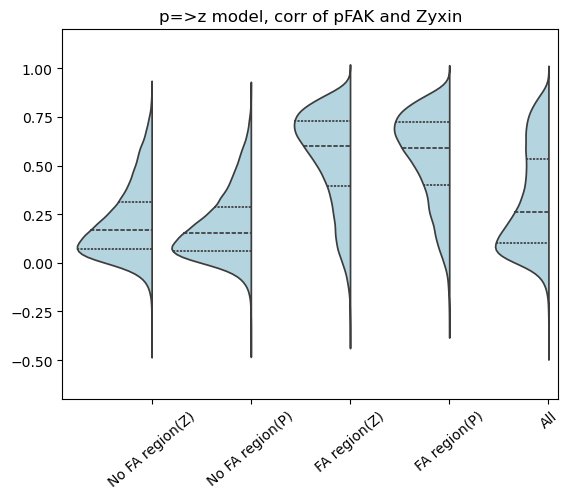

In [76]:
bscz = corr_matrix_zp[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zp[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zp[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zp[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zp[flag_mask>=0.99]


sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')

plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)
plt.title('p=>z model, corr of pFAK and Zyxin')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)','FA region(Z)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f3f2855e4b0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

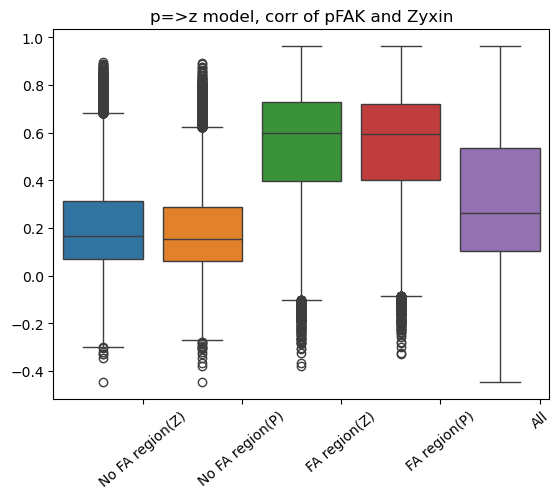

In [91]:
bscz = corr_matrix_zp[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zp[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zp[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zp[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zp[flag_mask>=0.99]


sns.boxplot([bscz,bscp,scz,scp,total_image_corr])

# plt.xlim(-0.5,4.5)
# plt.ylim(-0.7,1.2)
plt.title('p=>z model, corr of pFAK and Zyxin')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)','FA region(Z)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f3f430b04a0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

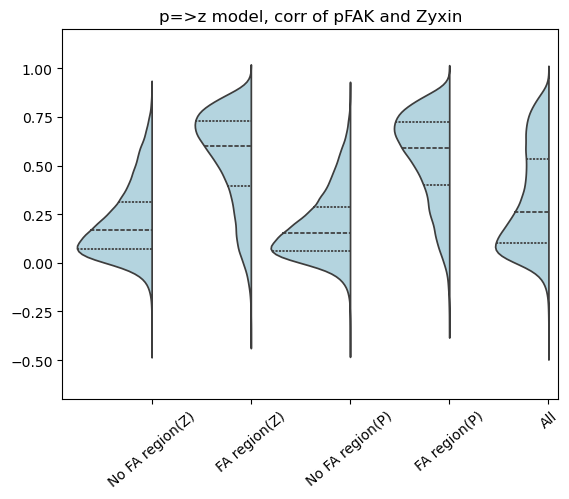

In [77]:
bscz = corr_matrix_zp[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zp[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zp[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zp[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zp[flag_mask>=0.99]


sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')

plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)
plt.title('p=>z model, corr of pFAK and Zyxin')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)','FA region(Z)', 'No FA region(P)', 'FA region(P)', 'All'],rotation=40)


(0.0, 1.2)

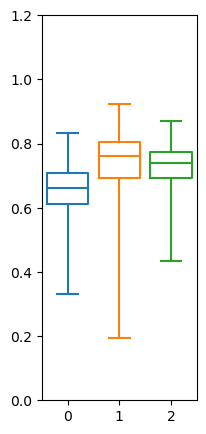

In [59]:
fig,ax=plt.subplots(1,1,figsize=(2, 5), dpi=100)
sns.boxplot([z_p_corr[z_p_corr>-1],z_n_corr[z_n_corr>-1],p_n_corr[p_n_corr>-1]],fill=False, whis=(0,100))

plt.xlim(-0.5,2.5)
plt.ylim(0,1.2)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(2, 5), dpi=100)
sns.boxplot([z_p_corr[z_p_corr>-1],z_n_corr[z_n_corr>-1],p_n_corr[p_n_corr>-1]],fill=False, whis=(0,100))

plt.xlim(-0.5,2.5)
plt.ylim(0,1.2)

In [37]:
corr_matrix_zp[200,16,16]


0.29754844307899475

<Axes: >

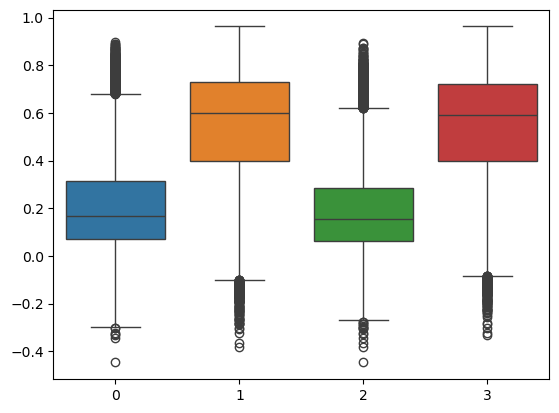

In [10]:
sns.boxplot([bscz,scz,bscp,scp])

([<matplotlib.axis.XTick at 0x7f3f5be69dc0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

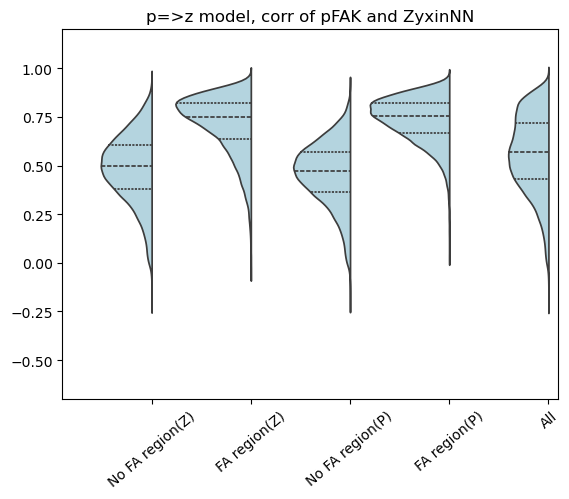

In [70]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('p=>z model, corr of pFAK and ZyxinNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)', 'No FA region(P)','FA region(P)', 'All'],rotation=40)
# sns.boxplot([bscz,scz,bscp,scp,total_image_corr])


([<matplotlib.axis.XTick at 0x7f3f319a8fe0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

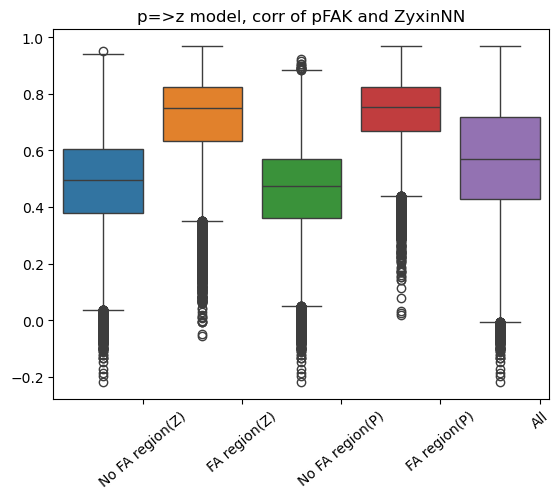

In [90]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

sns.boxplot([bscz,scz,bscp,scp,total_image_corr])
# plt.xlim(-0.5,4.5)
# plt.ylim(-0.7,1.2)

plt.title('p=>z model, corr of pFAK and ZyxinNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)', 'No FA region(P)','FA region(P)', 'All'],rotation=40)
# sns.boxplot([bscz,scz,bscp,scp,total_image_corr])

([<matplotlib.axis.XTick at 0x7f3f432c1cd0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

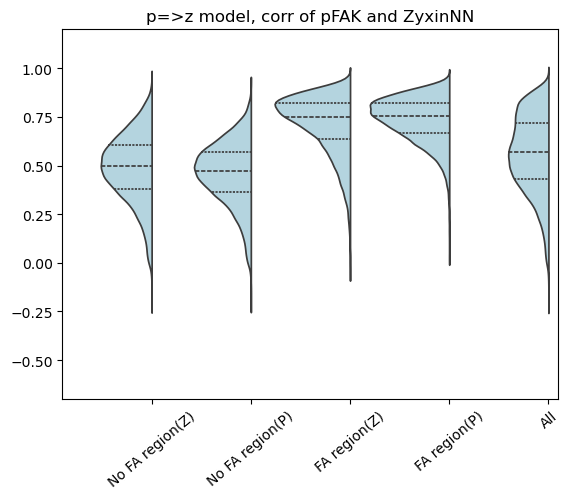

In [78]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('p=>z model, corr of pFAK and ZyxinNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)','FA region(Z)', 'FA region(P)', 'All'],rotation=40)
# sns.boxplot([bscz,scz,bscp,scp,total_image_corr])


([<matplotlib.axis.XTick at 0x7f3f3af68fe0>,
 [Text(0.4, 0, 'zyxin<->pFAK'),
  Text(1.4, 0, 'zyxin<->zyxinNN'),
  Text(2.4, 0, 'pFAK<->zyxinNN')])

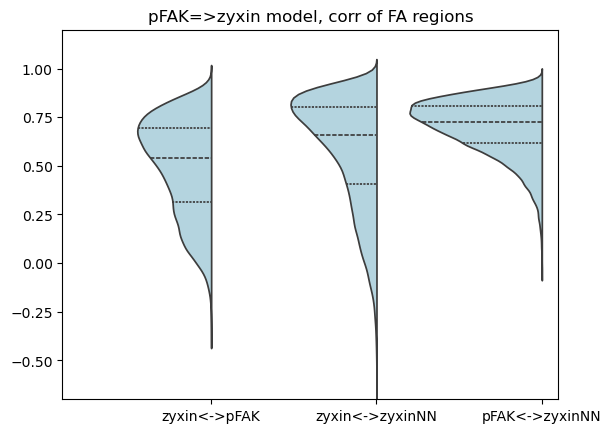

In [85]:
np_scz = corr_matrix_np[np.logical_and(np.logical_or(flag_sc_z>0.02,flag_sc_p>0.02),flag_mask>=0.99)]
np_bscp = corr_matrix_np[np.logical_and(np.logical_and(flag_sc_z<=0.02,flag_sc_p<=0.02),flag_mask>=0.99)]

zp_scz = corr_matrix_zp[np.logical_and(np.logical_or(flag_sc_z>0.02,flag_sc_p>0.02),flag_mask>=0.99)]
zp_bscp = corr_matrix_zp[np.logical_and(np.logical_and(flag_sc_z<=0.02,flag_sc_p<=0.02),flag_mask>=0.99)]

zn_scz = corr_matrix_zn[np.logical_and(np.logical_or(flag_sc_z>0.02,flag_sc_p>0.02),flag_mask>=0.99)]
zn_bscp = corr_matrix_zn[np.logical_and(np.logical_and(flag_sc_z<=0.02,flag_sc_p<=0.02),flag_mask>=0.99)]


sns.violinplot([zp_scz,zn_scz,np_scz],split=True, inner="quart",color='lightblue')

plt.xlim(-0.5,2.5)
plt.ylim(-0.7,1.2)

plt.title('pFAK=>zyxin model, corr of FA regions')

plt.xticks(np.arange(0.4,3.4), ['zyxin<->pFAK', 'zyxin<->zyxinNN','pFAK<->zyxinNN'])
# sns.boxplot([bscz,scz,bscp,scp,total_image_corr])

In [34]:
corr_matrix_np.shape

(600, 32, 32)

In [95]:
[[]]*5

[[], [], [], [], []]

([<matplotlib.axis.XTick at 0x7f3f500622a0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

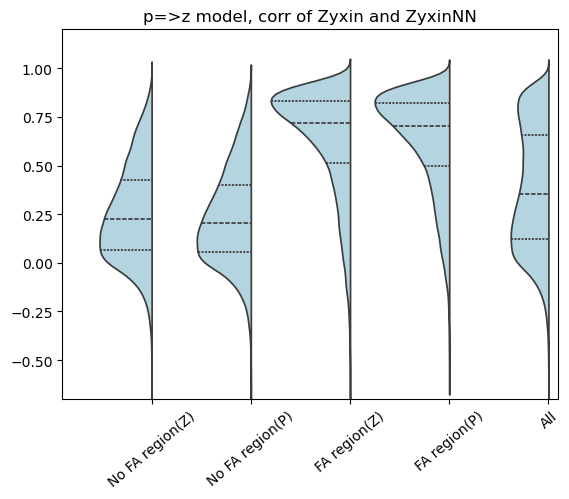

In [73]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('p=>z model, corr of Zyxin and ZyxinNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)','No FA region(P)', 'FA region(Z)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f3f7f629d00>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

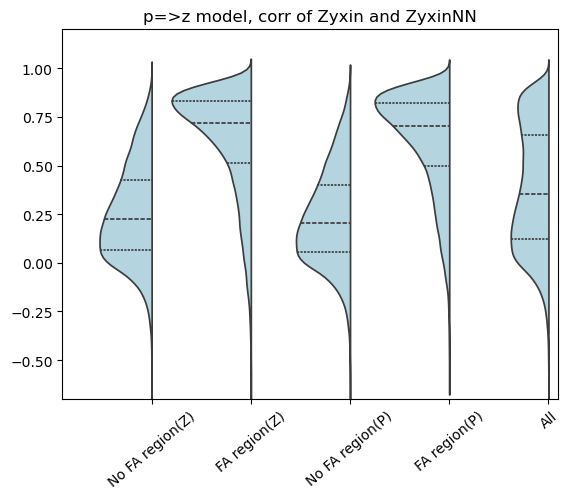

In [74]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('p=>z model, corr of Zyxin and ZyxinNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)','No FA region(P)', 'FA region(P)', 'All'],rotation=40)


<Axes: ylabel='Count'>

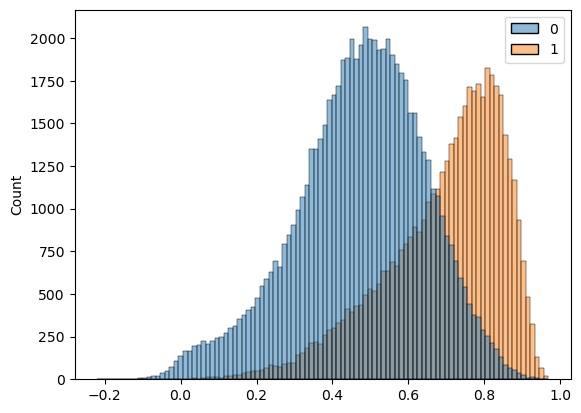

In [12]:




sns.histplot([bscz,scz])